In [1]:
import sys
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

from tqdm import tqdm
from matplotlib import pyplot as plt

from src.visualization import set_themes
from src.preprocessing import construct_features_meta
from src.preprocessing.data_loader import load_data
from src.sampler import BayesianSampler
from src.losses.bayesian_personalized_ranking import BayesianPersonalizedRankingLoss
from src.models.matrix_factorization import MatrixFactorization
from src.baremetal import gather_dense

from collections import defaultdict

set_themes()
tf.config.list_logical_devices()

2026-01-21 10:08:11.215592: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
failed to send, dropping 5 traces to intake at http://localhost:8126/v0.5/traces after 3 retries
/home/hafidh_rendyanto/documents/peppermint-matrix/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


2026-01-21 10:08:14.646884: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1768990094.648571 3282033 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19164 MB memory:  -> device: 0, name: NVIDIA A10G, pci bus id: 0000:00:1e.0, compute capability: 8.6


[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [2]:
# set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# Load Datasets

In [3]:
train_user_interaction = load_data("dataset/yelp2018/train.txt")
train_features_meta = construct_features_meta(train_user_interaction)
train_user_interaction

,user_id,item_id
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
...,...,...
1237254,31667,22984
1237255,31667,12943
1237256,31667,29149
1237257,31667,4927


In [4]:
test_user_interaction = load_data("dataset/yelp2018/test.txt")
test_features_meta = construct_features_meta(test_user_interaction)
test_user_interaction

,user_id,item_id
0,0,795
1,0,694
2,0,1531
3,0,14517
4,0,8784
...,...,...
324142,31667,33811
324143,31667,10482
324144,31667,9585
324145,31667,36460


In [5]:
user_items = train_user_interaction.groupby("user_id")["item_id"].apply(set).to_dict()
item_users = train_user_interaction.groupby("item_id")["user_id"].apply(set).to_dict()

In [6]:
# train dataset features meta without vocabulary
{feature_name: {k: v for k, v in meta.items() if k not in ["vocabulary"]} for feature_name, meta in train_features_meta.items()}

{'user_id': {'dtype': 'int64', 'unique_count': 31668},
 'item_id': {'dtype': 'int64', 'unique_count': 38048}}

In [7]:
# test dataset features meta without vocabulary
{feature_name: {k: v for k, v in meta.items() if k not in ["vocabulary"]} for feature_name, meta in test_features_meta.items()}

{'user_id': {'dtype': 'int64', 'unique_count': 31668},
 'item_id': {'dtype': 'int64', 'unique_count': 36073}}

# Model Definition

In [8]:
sampler = BayesianSampler(item_set=train_features_meta["item_id"]["vocabulary"], user_items=user_items)

model = MatrixFactorization(
    train_features_meta, 
    embedding_dimension_count=64,
    l2_regularization=0.0
)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss_functions=[
        BayesianPersonalizedRankingLoss()
    ],
    sampler=sampler,
    evaluation_cutoffs=[2, 10, 50]
)

# Model Training

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    {
        "user_id": train_user_interaction["user_id"].values,
        "item_id": train_user_interaction["item_id"].values
    }
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    {
        "user_id": test_user_interaction["user_id"].values,
        "item_id": test_user_interaction["item_id"].values
    }
)
print(f"Training Dataset: {len(train_dataset)}")
print(f"Test Dataset: {len(test_dataset)}")

Training Dataset: 1237259
Test Dataset: 324147


In [10]:
callbacks = []
callbacks.append(
    keras.callbacks.EarlyStopping(
        monitor="test_recall@10",
        mode="max",
        patience=0,
        restore_best_weights=True,
        verbose=1
    )
)

model.fit(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    nepochs=5,
    shuffle=True,
    batch_size=16384,
    callbacks=callbacks
)

OE [5/5]: 100%|████████████████████████████████████████████████████████████████████████████████| 31668/31668 [00:23<00:00, 1336.08it/s, recall@10=0.0334, test_recall@10=0.0211]

Restoring model weights from the end of the best epoch: 5.


{'loss': 0.09503144025802612,
 'step_delta': 8459,
 'test_loss': 0.17345137894153595,
 'hitrate@50': 0.900909423828125,
 'recall@50': 0.1137806624174118,
 'precision@50': 0.07946064323186874,
 'map@50': 0.18150147795677185,
 'ndcg@50': 0.39753371477127075,
 'mrr@50': 0.28194764256477356,
 'hitrate@10': 0.5898067355155945,
 'recall@10': 0.033388782292604446,
 'precision@10': 0.11258050799369812,
 'map@10': 0.23875586688518524,
 'ndcg@10': 0.33536818623542786,
 'mrr@10': 0.2657712697982788,
 'hitrate@2': 0.24368447065353394,
 'recall@2': 0.008353710174560547,
 'precision@2': 0.13805735111236572,
 'map@2': 0.19461286067962646,
 'ndcg@2': 0.20746265351772308,
 'mrr@2': 0.19461286067962646,
 'test_hitrate@50': 0.4248768389225006,
 'test_recall@50': 0.07393645495176315,
 'test_precision@50': 0.013923832215368748,
 'test_map@50': 0.05763227865099907,
 'test_ndcg@50': 0.1377546191215515,
 'test_mrr@50': 0.07032899558544159,
 'test_hitrate@10': 0.16527725756168365,
 'test_recall@10': 0.02114724

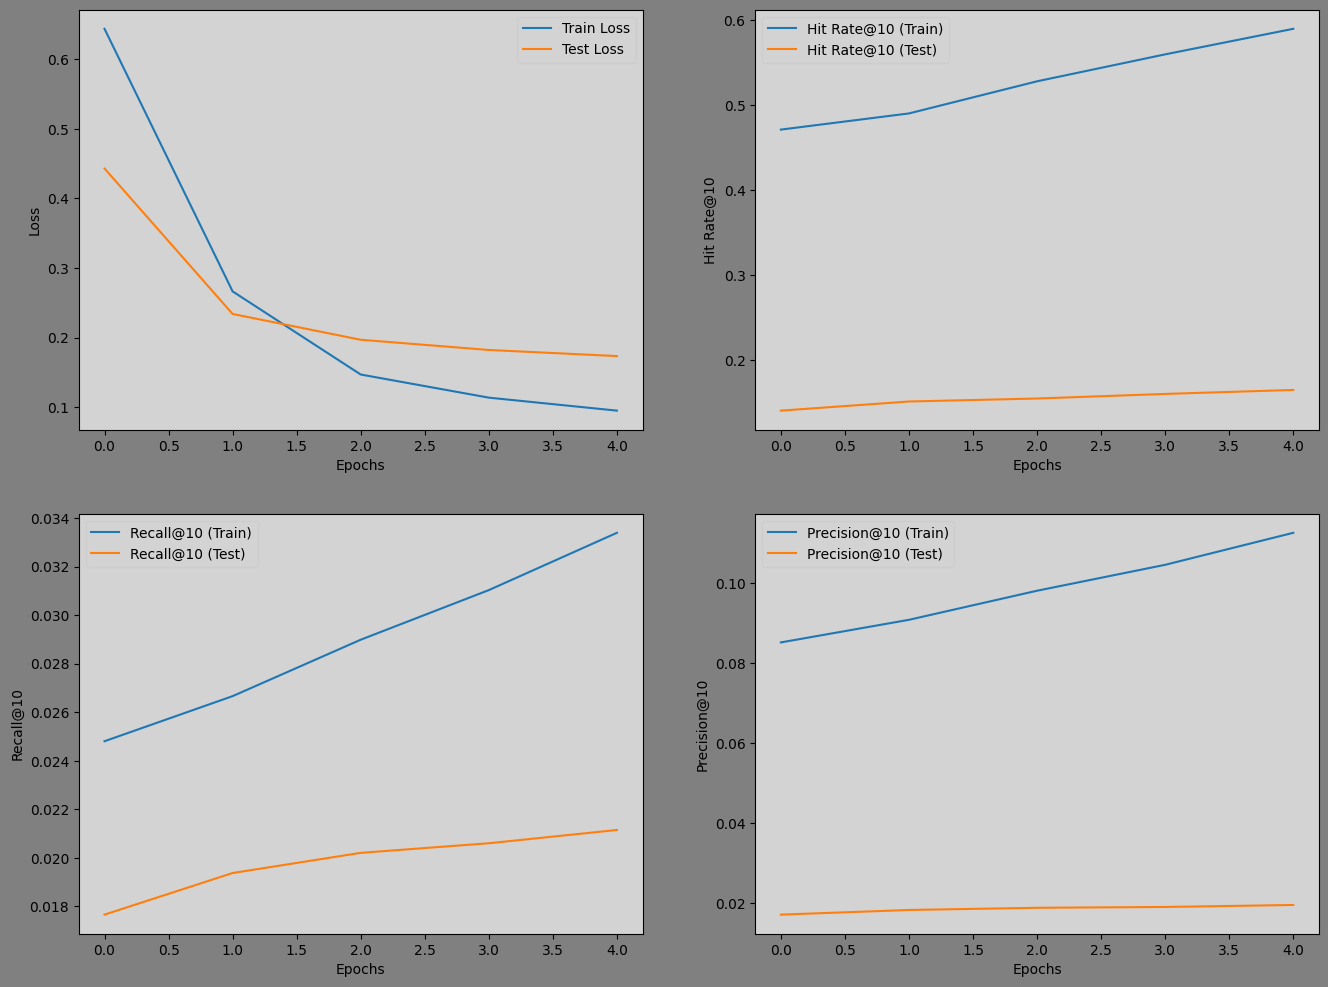

failed to send, dropping 1 traces to intake at http://localhost:8126/v0.5/traces after 3 retries, 7 additional messages skipped


In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

# Loss History
ax[0, 0].plot(model.train_loss_history, label="Train Loss")
ax[0, 0].plot(model.test_loss_history, label="Test Loss")
ax[0, 0].set_xlabel("Epochs")
ax[0, 0].set_ylabel("Loss")
ax[0, 0].legend()

# Hit Rate History
ax[0, 1].plot(model.train_hitrate_history[10], label="Hit Rate@10 (Train)")
ax[0, 1].plot(model.test_hitrate_history[10], label="Hit Rate@10 (Test)")
ax[0, 1].set_xlabel("Epochs")
ax[0, 1].set_ylabel("Hit Rate@10")
ax[0, 1].legend()

# Recall History
ax[1, 0].plot(model.train_recall_history[10], label="Recall@10 (Train)")
ax[1, 0].plot(model.test_recall_history[10], label="Recall@10 (Test)")
ax[1, 0].set_xlabel("Epochs")
ax[1, 0].set_ylabel("Recall@10")
ax[1, 0].legend()

# Precision History
ax[1, 1].plot(model.train_precision_history[10], label="Precision@10 (Train)")
ax[1, 1].plot(model.test_precision_history[10], label="Precision@10 (Test)")
ax[1, 1].set_xlabel("Epochs")
ax[1, 1].set_ylabel("Precision@10")
ax[1, 1].legend()

plt.show()

# Sandbox: Evaluation

In [12]:
model.evaluation_cutoffs = [5]

In [29]:
model.metrics

[<Mean name=train_loss>,
 <Mean name=test_loss>,
 <Mean name=train_hitrate@2>,
 <Mean name=train_recall@2>,
 <Mean name=train_precision@2>,
 <Mean name=test_hitrate@2>,
 <Mean name=test_recall@2>,
 <Mean name=test_precision@2>,
 <Mean name=train_hitrate@10>,
 <Mean name=train_recall@10>,
 <Mean name=train_precision@10>,
 <Mean name=test_hitrate@10>,
 <Mean name=test_recall@10>,
 <Mean name=test_precision@10>,
 <Mean name=train_hitrate@50>,
 <Mean name=train_recall@50>,
 <Mean name=train_precision@50>,
 <Mean name=test_hitrate@50>,
 <Mean name=test_recall@50>,
 <Mean name=test_precision@50>]

In [27]:
batch_size = 128
train_interaction_matrix = model.construct_interaction_matrix(model.construct_interaction_history(train_dataset.batch(16384)))
test_interaction_matrix = model.construct_interaction_matrix(model.construct_interaction_history(test_dataset.batch(16384)))
user_candidates = tf.constant(model.user_lookup_layer.get_vocabulary()[1:], dtype=tf.int64)
item_candidates = tf.constant(model.item_lookup_layer.get_vocabulary(), dtype=tf.int64)
user_dataset = tf.data.Dataset.from_tensor_slices(user_candidates)
user_dataset = user_dataset.batch(batch_size)

maxk = max(model.evaluation_cutoffs)
metrics_aggregate = {}
with tqdm(total=model.user_lookup_layer.vocabulary_size() - 1, ncols=176) as pbar:
    for step, user_batch in enumerate(user_dataset):
        user_indices = model.user_lookup_layer(user_batch)
        user_embedding = model.user_embedding(user_batch)
        candidate_item_embedding = model.item_embedding(item_candidates)
        predicted_scores = tf.matmul(user_embedding, tf.transpose(candidate_item_embedding))
        # predicted_train_rankings = tf.argsort(tf.argsort(predicted_scores, direction='DESCENDING', axis=-1), axis=-1) + 1 # argsort twice gets you rankings of each item | nlog(n)
        sorted_train_scores, predicted_train_indices = tf.math.top_k(predicted_scores, k=maxk) # partition + partial sort gives you faster result  | n + klog(k)

        # Train Metrics
        train_ground_truth = gather_dense(train_interaction_matrix, user_indices) # [B, num_items]
        train_actual_positive_count = tf.reduce_sum(train_ground_truth, axis=-1) # actual positives per user [B]
        for k in sorted(model.evaluation_cutoffs, reverse=True):
            positions = tf.range(k, dtype=tf.float32) # [K]
            predicted_train_indices_k = predicted_train_indices[:, :k]
            # train_true_positives = tf.cast((predicted_train_rankings <= k) * train_ground_truth, tf.int32)
            # train_true_positive_count = tf.reduce_sum(train_true_positives, axis=-1) # true_positives per user
            train_true_positives = tf.gather(train_ground_truth, predicted_train_indices_k, batch_dims=-1) # this is equivalent to the commented lines above | [B, K]
            train_true_positive_count = tf.reduce_sum(train_true_positives, axis=-1) # [B]

            # Hit Rate@k
            train_hit = tf.cast(train_true_positive_count > 0, tf.float32) # [B]
            # Recall@k
            train_recall = tf.math.divide_no_nan(train_true_positive_count, train_actual_positive_count) # [B]
            # Precision@k
            train_precision = tf.math.divide_no_nan(train_true_positive_count, k) # [B]
            # MAP@k
            train_map = tf.math.divide_no_nan(
                tf.reduce_sum(
                    (tf.cumsum(train_true_positives, axis=-1) / (positions + 1)) 
                    * train_true_positives, 
                    axis=-1
                ), 
                train_true_positive_count
            )
            # NDCG@k
            log_discount = tf.math.log(positions + 2) / tf.math.log(2.0) # [K]
            train_dcg = tf.reduce_sum(train_true_positives / log_discount, axis=-1) # [B]
            train_ideal_true_positives = tf.cast(positions[tf.newaxis, :] < train_true_positive_count[:, tf.newaxis], tf.float32) # [B, K]
            train_idcg = tf.reduce_sum(train_ideal_true_positives / log_discount, axis=-1) # [B]
            train_ndcg = tf.math.divide_no_nan(train_dcg, train_idcg) # [B]
            # MRR@k
            reciprocal_ranks = 1 / tf.reduce_min(tf.where(train_true_positives==1, train_true_positives * (positions + 1), float('inf')), axis=-1) # [B]
            
            
            
            # model.train_hitrate_tracker[k].update_state(train_hit)
            # model.train_recall_tracker[k].update_state(train_recall)
            # model.train_precision_tracker[k].update_state(train_precision)
            # metrics_aggregate.update({
            #     f"hitrate@{k}": float(model.train_hitrate_tracker[k].result()),
            #     f"recall@{k}": float(model.train_recall_tracker[k].result()),
            #     f"precision@{k}": float(model.train_precision_tracker[k].result())
            # })

            break
        
        break

failed to send, dropping 1 traces to intake at http://localhost:8126/v0.5/traces after 3 retries, 4 additional messages skipped
  0%|                                                                                                                                                 | 0/31668 [00:00<?, ?it/s]


In [28]:
reciprocal_ranks

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([0.5       , 1.        , 0.5       , 0.25      , 0.33333334,
       0.        , 0.        , 0.        , 0.        , 0.5       ,
       1.        , 0.5       , 1.        , 0.2       , 0.        ,
       1.        , 1.        , 0.5       , 0.2       , 1.        ,
       0.        , 0.        , 1.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.5       , 1.        ,
       0.        , 1.        , 1.        , 0.33333334, 0.        ,
       0.        , 0.        , 1.        , 1.        , 0.2       ,
       0.2       , 0.25      , 0.        , 1.        , 0.        ,
       0.        , 0.25      , 0.33333334, 0.        , 0.        ,
       0.        , 0.2       , 0.        , 1.        , 0.5       ,
       0.5       , 1.        , 1.        , 0.        , 0.        ,
       0.        , 0.5       , 0.33333334, 0.        , 1.        ,
       0.25      , 0.25      , 1.        , 1.        , 1.        ,
       0.5    

In [16]:
train_mrr

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([0.5       , 1.95      , 0.5       , 0.25      , 0.33333334,
       0.        , 0.        , 0.        , 0.        , 0.7       ,
       1.        , 0.5       , 1.        , 0.2       , 0.        ,
       1.25      , 1.7833334 , 0.5       , 0.2       , 2.2833335 ,
       0.        , 0.        , 1.        , 1.3333334 , 0.        ,
       0.        , 0.        , 0.        , 1.0333334 , 1.        ,
       0.        , 1.5333334 , 1.        , 0.33333334, 0.        ,
       0.        , 0.        , 2.0833335 , 1.        , 0.2       ,
       0.2       , 0.25      , 0.        , 1.5333334 , 0.        ,
       0.        , 0.25      , 0.33333334, 0.        , 0.        ,
       0.        , 0.2       , 0.        , 1.3333334 , 0.5       ,
       0.5       , 1.        , 1.        , 0.        , 0.        ,
       0.        , 0.7       , 0.33333334, 0.        , 1.5333334 ,
       0.25      , 0.25      , 1.95      , 1.8333334 , 1.        ,
       0.83333

In [26]:
train_true_positives

<tf.Tensor: shape=(128, 5), dtype=float32, numpy=
array([[0., 1., 0., 0., 0.],
       [1., 1., 0., 1., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0.],
       [1., 0., 1., 1., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 1., 1., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 1.],
       [1., 0., 0., 0.

In [25]:
tf.reduce_min(tf.where(train_true_positives==1, train_true_positives * (positions + 1), float('inf')), axis=-1)

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 2.,  1.,  2.,  4.,  3., inf, inf, inf, inf,  2.,  1.,  2.,  1.,
        5., inf,  1.,  1.,  2.,  5.,  1., inf, inf,  1.,  1., inf, inf,
       inf, inf,  2.,  1., inf,  1.,  1.,  3., inf, inf, inf,  1.,  1.,
        5.,  5.,  4., inf,  1., inf, inf,  4.,  3., inf, inf, inf,  5.,
       inf,  1.,  2.,  2.,  1.,  1., inf, inf, inf,  2.,  3., inf,  1.,
        4.,  4.,  1.,  1.,  1.,  2.,  3.,  1.,  1.,  2., inf, inf, inf,
       inf,  1.,  1.,  1.,  5.,  1.,  2.,  2.,  4., inf,  2.,  5., inf,
        2.,  2.,  1.,  1.,  2., inf,  1.,  1., inf, inf, inf,  4.,  1.,
        1., inf, inf,  3., inf,  3.,  1., inf, inf,  1.,  1.,  5., inf,
        1., inf, inf,  2.,  2.,  4.,  5.,  5., inf,  5.,  4.],
      dtype=float32)>

In [24]:
1 / tf.reduce_min(tf.where(train_true_positives==1, train_true_positives * (positions + 1), float('inf')), axis=-1)

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([0.5       , 1.        , 0.5       , 0.25      , 0.33333334,
       0.        , 0.        , 0.        , 0.        , 0.5       ,
       1.        , 0.5       , 1.        , 0.2       , 0.        ,
       1.        , 1.        , 0.5       , 0.2       , 1.        ,
       0.        , 0.        , 1.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.5       , 1.        ,
       0.        , 1.        , 1.        , 0.33333334, 0.        ,
       0.        , 0.        , 1.        , 1.        , 0.2       ,
       0.2       , 0.25      , 0.        , 1.        , 0.        ,
       0.        , 0.25      , 0.33333334, 0.        , 0.        ,
       0.        , 0.2       , 0.        , 1.        , 0.5       ,
       0.5       , 1.        , 1.        , 0.        , 0.        ,
       0.        , 0.5       , 0.33333334, 0.        , 1.        ,
       0.25      , 0.25      , 1.        , 1.        , 1.        ,
       0.5    